In [14]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import pandas as pd
from scipy.ndimage import interpolation
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score


## SVM Preprocessing

As found in the SVM file

In [2]:
X = np.loadtxt('data.txt', skiprows=0)
X = normalize(X)
# possible digits
digits = np.array([0,1,2,3,4,5,6,7,8,9])
y = np.repeat(digits, 200, axis=0)


## Random Forest Preprocessing

As found in the file regarding Random Forests.

In [3]:
#create features' names
numbers = np.arange(1, 241)
features = list(str(' ') * 240)

for i in range (len(numbers)):
    features[i] = "f" + str(numbers[i])

#load the data in - should be 2000*240
digitPics = pd.read_csv("data.txt", sep = "\s+", header = None, names = features)

# create target vector by repeating digits 200 times
digitLabels = np.repeat(np.array([0,1,2,3,4,5,6,7,8,9]), 200, axis=0)

y2=digitLabels


def moments(image):
    c0,c1 = np.mgrid[:image.shape[0],:image.shape[1]] # A trick in numPy to create a mesh grid
    totalImage = np.sum(image) #sum of pixels
    m0 = np.sum(c0*image)/totalImage #mu_x
    m1 = np.sum(c1*image)/totalImage #mu_y
    m00 = np.sum((c0-m0)**2*image)/totalImage #var(x)
    m11 = np.sum((c1-m1)**2*image)/totalImage #var(y)
    m01 = np.sum((c0-m0)*(c1-m1)*image)/totalImage #covariance(x,y)
    mu_vector = np.array([m0,m1]) # Notice that these are \mu_x, \mu_y respectively
    covariance_matrix = np.array([[m00,m01],[m01,m11]]) # Do you see a similarity between the covariance matrix
    return mu_vector, covariance_matrix

def deskew(image):
    c,v = moments(image)
    alpha = v[0,1]/v[0,0]
    affine = np.array([[1,0],[alpha,1]])
    ocenter = np.array(image.shape)/2.0
    offset = c-np.dot(affine,ocenter)
    return interpolation.affine_transform(image,affine,offset=offset)

digitsDeskew = digitPics
for numbers in range (digitsDeskew.shape[0]):
    digitsDeskew.iloc[numbers] = deskew(np.asarray(digitPics.iloc[numbers]).reshape(16,15)).reshape(1,240)

digitPicsNorm = normalize(digitsDeskew)

    
postPCAPics = digitPicsNorm

pca = PCA(random_state=0)
pca.fit(postPCAPics)

topFeatures = pca.transform(postPCAPics)[:, :100]
#create features' names
PCANumbers = np.arange(1, 101)
PCAFeatures = list(str(' ') * 100)

for i in range (len(PCANumbers)):
    PCAFeatures[i] = "pc" + str(PCANumbers[i])
    
X2 = pd.DataFrame(topFeatures, columns = PCAFeatures)

## Functions for the Digitwise Acc and Combined Predictor

As also found in the file for SVM

In [4]:
def digitwise_accuracy(pred_y, test_y):
    prederrorstuff = []
    for i in range(10):
        curr_acc = []
        for j in range(len(pred_y)):
            if pred_y[j] == i:
                if pred_y[j] == test_y[j]:
                    curr_acc.append(1)
                else:
                    curr_acc.append(0)
        prederrorstuff.append(np.mean(curr_acc))

    return prederrorstuff

In [5]:
def combined_predictor(predictions, pred_accuracies):
    combined_predictions = []
    combined_pred_choice = []
    for i in range(len(predictions[0])):
        curr_pred = 0
        curr_acc = 0
        curr_mod = 0
        
        for j in range(len(pred_accuracies)):
            new_pred = predictions[j][i]
            new_acc = pred_accuracies[j][new_pred]
            if new_acc > curr_acc:
                curr_pred = new_pred
                curr_acc = new_acc
                curr_mod = j
                
        combined_predictions.append(curr_pred)
        combined_pred_choice.append(curr_mod)
        
    return combined_predictions

## Combined Predictor SVM + RF

Both predictors are using input data as formatted in their original works. The Cross Validation procedure works as explained in the file on SVM with identical sizes for training, validation and test set.

The plot and accuracies show that the combined predictor is worse than the SVM. This is probably caused by the Random Forest having an on-average worse performance than the SVM on predicting all of the digits, rendering the theoretical advantage of the combined predictor mute. Interestingly, looking at the individual plots of both SVM and RF shows that both of them trendwise score relatively worse on the same digits. This might indicate that the error might not be characteristic of the model itself, but of the noise in the data.

Mean k-Fold accuracy using Combined Kernel: 0.9705
Mean k-Fold accuracy using SVM: 0.9765
Mean k-Fold accuracy using Random Forest: 0.951


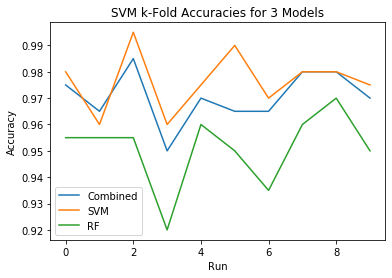

In [19]:
# Lists to hold accuracy tables for kernels
kf_acc_comb = []
kf_acc_poly = []
kf_acc_rf = []

# List to hold digitwise accuracies
dw_acc_comb = []
dw_acc_poly = []
dw_acc_rf = []

# kFold based on example in https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
kf = KFold(n_splits=10, shuffle=True, random_state=1001)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X2_train, X2_test = X2.iloc[train_index,:], X2.iloc[test_index,:]
    y2_train, y2_test = y2[train_index], y2[test_index]
    
    # Separate training into train and validation set.
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state = 101010)
    X2_train, X2_val, y2_train, y2_val = train_test_split(X2_train, y2_train, test_size=0.5, random_state = 101010)
    
    # Polynomial Kernel
    svc_poly= svm.SVC(kernel="poly", degree=3, decision_function_shape="ovo")
    # RBF Kernel
    rf = RandomForestClassifier(n_estimators = 110, min_samples_split = 16, 
                               min_samples_leaf = 11, max_depth = 5, criterion = 'gini', bootstrap = True)
    
    # Fitting Process
    svc_poly.fit(X_train, y_train)
    rf.fit(X2_train, y2_train)
    
    # Validation Process
    y_val_pred_poly = svc_poly.predict(X_val)
    y_val_pred_rf = rf.predict(X2_val)
    
    # Testing
    y_pred_poly = svc_poly.predict(X_test)
    y_pred_rf = rf.predict(X2_test)
    y_pred_comb = combined_predictor([list(y_pred_poly), list(y_pred_rf)], [digitwise_accuracy(y_val_pred_poly, y_val), digitwise_accuracy(list(y_val_pred_rf), list(y2_val))])
    
    # Append Accuracies to List
    kf_acc_comb.append(accuracy_score(y_test, y_pred_comb))
    kf_acc_poly.append(accuracy_score(y_test, y_pred_poly))
    kf_acc_rf.append(accuracy_score(y2_test, y_pred_rf))
    
    # Append Digitwise accuracies
    dw_acc_comb.append(digitwise_accuracy(y_pred_comb, y_test))
    dw_acc_poly.append(digitwise_accuracy(y_pred_poly, y_test))
    dw_acc_rf.append(digitwise_accuracy(list(y_pred_rf), list(y2_test)))
    
print("Mean k-Fold accuracy using Combined Kernel: " + str(np.mean(kf_acc_comb)))
print("Mean k-Fold accuracy using SVM: " + str(np.mean(kf_acc_poly)))
print("Mean k-Fold accuracy using Random Forest: " + str(np.mean(kf_acc_rf)))

plt.plot(kf_acc_comb, label="Combined")
plt.plot(kf_acc_poly, label="SVM")
plt.plot(kf_acc_rf, label="RF")
plt.title("SVM k-Fold Accuracies for 3 Models")
plt.xlabel("Run")
plt.ylabel("Accuracy")
plt.legend()